In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')
%matplotlib inline

# Exploration

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
test_id = test['id']
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [3]:
print(train.shape)
train.head()

(300000, 25)


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,A,B,A,A,B,D,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,B,A,A,A,B,B,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,A,A,A,C,B,D,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,A,A,A,C,B,D,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,A,B,A,A,B,B,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [4]:
print(test.shape)
test.head()

(200000, 24)


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,A,B,A,C,B,D,A,E,E,G,0.331261,0.551131,0.486284,0.156058,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,A,B,A,C,B,D,A,E,C,L,0.402404,0.617546,0.296852,0.187440,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,A,B,A,C,B,D,A,E,C,F,0.530677,0.618126,0.760865,0.199872,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,A,A,B,A,B,D,A,E,E,F,0.439653,0.487403,0.715786,0.192808,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,A,B,A,A,B,B,A,E,E,I,0.389844,0.752760,0.315269,0.191734,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


In [5]:
sample.head()

,id,target
0,0,0.5
1,5,0.5
2,15,0.5
3,16,0.5
4,17,0.5


In [6]:
print(train.info())
print("=====================")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

<AxesSubplot:>

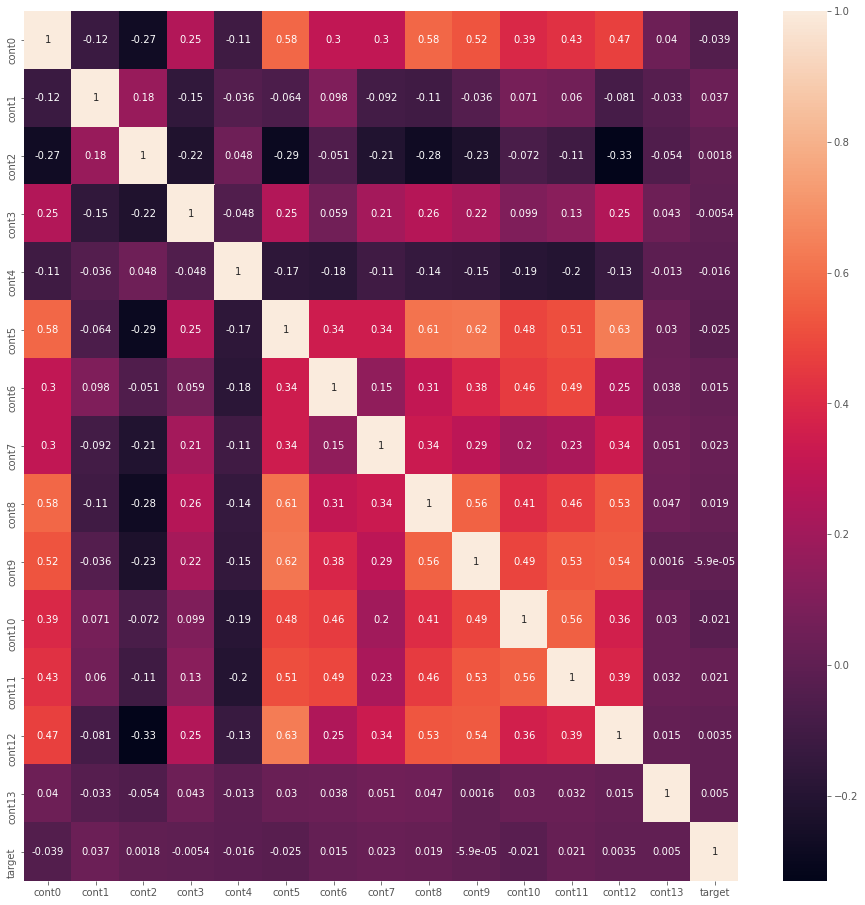

In [7]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True)

# Data Cleaning

Check if any value from the categorical variable is not in train or test

In [8]:
cat = train.select_dtypes(include=object)
for i in cat:
    uniquetrain = train[i].unique()
    uniquetest = test[i].unique()
    print(i)
    print(uniquetrain)
    print(uniquetest)
    print("-----------------------")

cat0
['A' 'B']
['A' 'B']
-----------------------
cat1
['B' 'A']
['B' 'A']
-----------------------
cat2
['A' 'B']
['A' 'B']
-----------------------
cat3
['A' 'C' 'D' 'B']
['C' 'A' 'D' 'B']
-----------------------
cat4
['B' 'C' 'A' 'D']
['B' 'A' 'C' 'D']
-----------------------
cat5
['D' 'B' 'A' 'C']
['D' 'B' 'A' 'C']
-----------------------
cat6
['A' 'B' 'D' 'C' 'E' 'I' 'G' 'H']
['A' 'B' 'C' 'D' 'E' 'I' 'H']
-----------------------
cat7
['E' 'B' 'D' 'G' 'F' 'A' 'C' 'I']
['E' 'D' 'B' 'G' 'F' 'I' 'A' 'C']
-----------------------
cat8
['C' 'A' 'G' 'E' 'D' 'F' 'B']
['E' 'C' 'D' 'G' 'A' 'F' 'B']
-----------------------
cat9
['I' 'F' 'N' 'K' 'B' 'L' 'G' 'H' 'O' 'A' 'J' 'M' 'C' 'D' 'E']
['G' 'L' 'F' 'I' 'A' 'K' 'M' 'O' 'N' 'H' 'B' 'J' 'C' 'E' 'D']
-----------------------


In [9]:
print(train.shape)
todrop = train[train['cat6'] == 'G'].index
train.drop(todrop, axis=0, inplace=True)
print(train.shape)

(300000, 25)
(299997, 25)


## Skewness

In [10]:
train.skew()

cont0     0.509880
cont1    -0.726462
cont2     0.171003
cont3     0.401534
cont4     0.743695
cont5     0.511147
cont6     0.871001
cont7     0.705154
cont8     0.725131
cont9     0.223224
cont10    0.084650
cont11   -0.030753
cont12    0.372885
cont13    0.130783
target   -0.201263
dtype: float64

# EDA

### Target

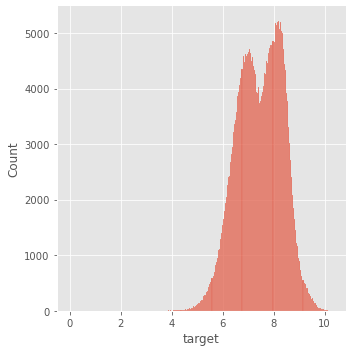

In [11]:
sns.displot(train['target'])

<AxesSubplot:xlabel='target'>

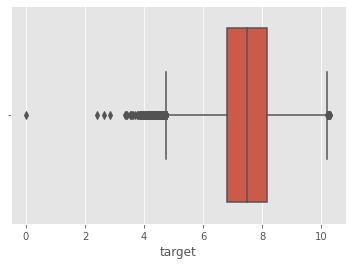

In [12]:
sns.boxplot(train['target'])

In [13]:
print(train.shape)
todrop = train[train['target'] < 3].index
train.drop(todrop, axis=0, inplace=True)
print(train.shape)

(299997, 25)
(299993, 25)


### Conclusion
I have gone through a lot of EDA, i explored all the features one by one to find anything interesing unfortunately i found nothing, no patterns, absolutley nothing. It seems the competition is all about the proper modelling technique. So i thought deleting all the useless cells (EDA related) is gonna make the notebook more readable and more organized.

Here is 2 random examples (1 Categorical, 1 Numerical) for the EDA i made for all the features.

### EDA Example

In [14]:
print(train['cat0'].value_counts())
print(test['cat0'].value_counts())

A    281466
B     18527
Name: cat0, dtype: int64
A    187700
B     12300
Name: cat0, dtype: int64


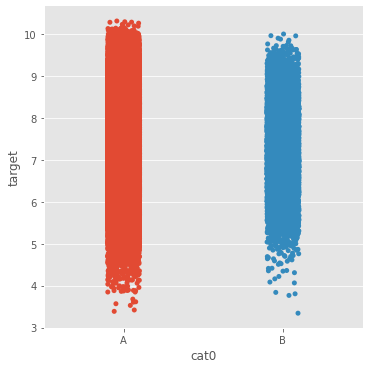

In [15]:
sns.catplot('cat0', 'target', data=train)

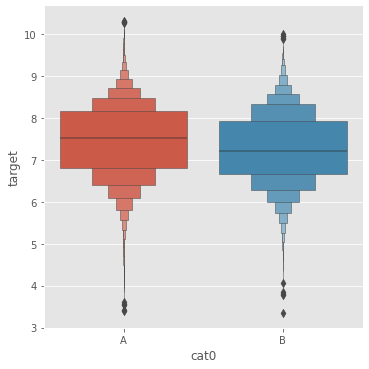

In [16]:
sns.catplot('cat0', 'target', data=train, kind='boxen')

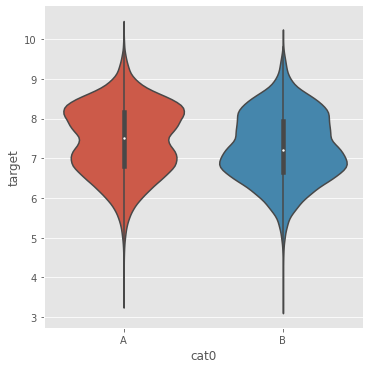

In [17]:
sns.catplot('cat0', 'target', data=train, kind='violin')

### cont5

<AxesSubplot:xlabel='cont5'>

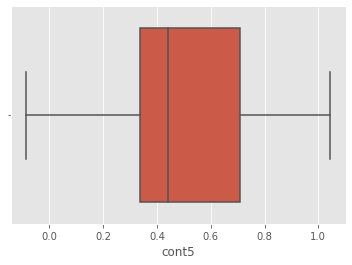

In [18]:
sns.boxplot(train['cont5'])

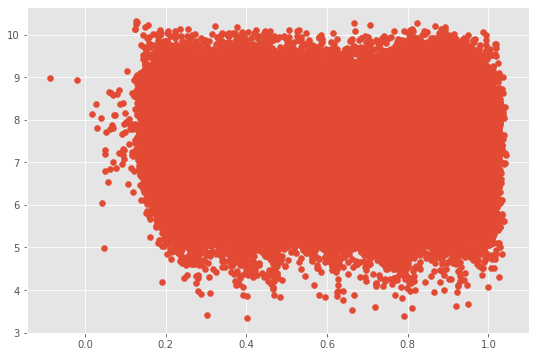

In [19]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont5'], train['target'])

# Encdoing categorical features

In [20]:
print(train.shape, test.shape)
cat = train.select_dtypes(include=object)
target = train['target']
train.drop('target', axis=1, inplace=True)
train = pd.get_dummies(train)
test = pd.get_dummies(test)
print(train.shape, test.shape)

(299993, 25) (200000, 24)
(299993, 69) (200000, 69)


In [21]:
train.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cat0_A,cat0_B,cat1_A,cat1_B,cat2_A,cat2_B,cat3_A,cat3_B,cat3_C,cat3_D,cat4_A,cat4_B,cat4_C,cat4_D,cat5_A,cat5_B,cat5_C,cat5_D,cat6_A,cat6_B,cat6_C,cat6_D,cat6_E,cat6_H,cat6_I,cat7_A,cat7_B,cat7_C,cat7_D,cat7_E,cat7_F,cat7_G,cat7_I,cat8_A,cat8_B,cat8_C,cat8_D,cat8_E,cat8_F,cat8_G,cat9_A,cat9_B,cat9_C,cat9_D,cat9_E,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
0,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# Modelling

In [22]:
# LightGBM
# lgb_model = lgb.LGBMRegressor(boosting="gbdt", max_depth=10, learning_rate=0.001, 
#                               reg_alpha=6.147694913504962, reg_lambda= 0.002457826062076097, 
#                               colsample_bytree=0.3, subsample=0.8, subsample_freq=6, 
#                               min_data_in_leaf=200, min_child_samples = 285, min_data_per_groups = 39, 
#                               num_leaves=244, num_iterations=20000)

# lgb_model = lgb.LGBMRegressor(boosting="gbdt", max_depth=10, learning_rate=0.0004, 
#                               reg_alpha=6.147694913504962, reg_lambda= 0.002457826062076097, 
#                               colsample_bytree=0.3, subsample=0.8, subsample_freq=6, 
#                               min_data_in_leaf=200, min_child_samples = 285, min_data_per_groups = 39, 
#                               num_leaves=244, num_iterations=50000)

lgb_model = lgb.LGBMRegressor(boosting="gbdt", max_depth=10, learning_rate=0.00045, 
                              reg_alpha=6.147694913504962, reg_lambda= 0.002457826062076097, 
                              colsample_bytree=0.3, subsample=0.8, subsample_freq=6, 
                              min_data_in_leaf=200, min_child_samples = 285, min_data_per_groups = 39, 
                              num_leaves=244, num_iterations=50000)

kf = KFold(n_splits=10, shuffle=True, random_state=1)
i = 1
test_pred_lgb = np.zeros(len(test))
for train_idx, val_idx in kf.split(train, target):
    X_train = train.iloc[train_idx]
    X_val = train.iloc[val_idx]
    y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]
    print("Training.......")
    lgb_model.fit(X_train, y_train)
    print("Fold:", i)
    print("LightGBM on validation")
    y_pred_lgb_val = lgb_model.predict(X_val)
    print("RMSE on validation (LightGBM):", np.sqrt(mean_squared_error(y_pred_lgb_val, y_val)))
    print("----------------------------------------")
    test_pred_lgb += lgb_model.predict(test)
    i += 1
print("DONE!")

Training.......
Fold: 1
LightGBM on validation
RMSE on validation (LightGBM): 0.8414371326920068
----------------------------------------
Training.......
Fold: 2
LightGBM on validation
RMSE on validation (LightGBM): 0.8442891118689341
----------------------------------------
Training.......
Fold: 3
LightGBM on validation
RMSE on validation (LightGBM): 0.8408411905255756
----------------------------------------
Training.......
Fold: 4
LightGBM on validation
RMSE on validation (LightGBM): 0.8408355126310143
----------------------------------------
Training.......
Fold: 5
LightGBM on validation
RMSE on validation (LightGBM): 0.8425494667037051
----------------------------------------
Training.......
Fold: 6
LightGBM on validation
RMSE on validation (LightGBM): 0.8403037718829217
----------------------------------------
Training.......
Fold: 7
LightGBM on validation
RMSE on validation (LightGBM): 0.8404099387701631
----------------------------------------
Training.......
Fold: 8
LightGBM o

In [ ]:
# Training.......
# Fold: 1
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8414371326920068
# ----------------------------------------
# Training.......
# Fold: 2
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8442891118689341
# ----------------------------------------
# Training.......
# Fold: 3
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8408411905255756
# ----------------------------------------
# Training.......
# Fold: 4
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8408355126310143
# ----------------------------------------
# Training.......
# Fold: 5
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8425494667037051
# ----------------------------------------
# Training.......
# Fold: 6
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8403037718829217
# ----------------------------------------
# Training.......
# Fold: 7
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8404099387701631
# ----------------------------------------
# Training.......
# Fold: 8
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8442997693812353
# ----------------------------------------
# Training.......
# Fold: 9
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8370488402977004
# ----------------------------------------
# Training.......
# Fold: 10
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8465475964470426
# ----------------------------------------
# DONE!





# Training.......
# Fold: 1
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8414515125694104
# ----------------------------------------
# Training.......
# Fold: 2
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8443293230241399
# ----------------------------------------
# Training.......
# Fold: 3
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8408829857020816
# ----------------------------------------
# Training.......
# Fold: 4
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8408562475137823
# ----------------------------------------
# Training.......
# Fold: 5
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8425811231170374
# ----------------------------------------
# Training.......
# Fold: 6
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8403041884222258
# ----------------------------------------
# Training.......
# Fold: 7
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8403903826386889
# ----------------------------------------
# Training.......
# Fold: 8
# LightGBM on validation
# RMSE on validation (LightGBM): 0.844317069896948
# ----------------------------------------
# Training.......
# Fold: 9
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8371227505368598
# ----------------------------------------
# Training.......
# Fold: 10
# LightGBM on validation
# RMSE on validation (LightGBM): 0.8465750191219925
# ----------------------------------------

In [23]:
test_pred_lgb /= 10
test_pred_lgb

array([7.59334316, 7.85966754, 7.59466558, ..., 7.50658192, 7.47524953,
       7.35829744])

In [24]:
sub3 = pd.DataFrame()
sub3['id'] = test_id
sub3['target'] = test_pred_lgb

# 0.84234
sub3.to_csv('submission000.csv', index=False) 

In [35]:
# Gradient Boosting
gboosting = GradientBoostingRegressor(n_estimators=50, learning_rate=0.2, 
                                      max_depth=6, random_state=1, subsample=0.6)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
i = 1
test_pred_gboosting = np.zeros(len(test))
for train_idx, val_idx in kf.split(train):
    X_train, X_val = train.iloc[train_idx], train.iloc[val_idx]
    y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]
    print("Training........")
    gboosting.fit(X_train, y_train)
    print("Fold:", i)
    print("Gradient Boosting on train")
    y_pred_gboosting_train = gboosting.predict(X_train)
    print("RMSE on train (Gradient Boosting):", np.sqrt(mean_squared_error(y_pred_gboosting_train, y_train)))
    print("XGBoost on validation")
    y_pred_gboosting_val = gboosting.predict(X_val)
    print("RMSE on validation (Gradient Boosting):", np.sqrt(mean_squared_error(y_pred_gboosting_val, y_val)))
    print("----------------------------------------")
    test_pred_gboosting += gboosting.predict(test)
    i += 1

Training........
Fold: 1
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8328818549511605
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.8472127571291864
----------------------------------------
Training........
Fold: 2
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8330223302578459
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.8509875803040288
----------------------------------------
Training........
Fold: 3
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8336406698352119
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.8476382547626823
----------------------------------------
Training........
Fold: 4
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8333552588371174
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.8475327338253198
----------------------------------------
Training........
Fold: 5
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0

In [51]:
test_pred_gboosting /= 10
test_pred_gboosting

array([7.55843311, 7.84008695, 7.62078581, ..., 7.49481851, 7.51211151,
       7.41552406])

Till now the LightGBM is the best model 

## Feature Importance

### LightGBM

[1208  875  622  743 1010  997  687  567  821  823  627  748   56   42
   88   42   48   82   94   81   89   27   29   63   32   44   25   46
   36   38   40   23   15   37   26   33   34   14   22    4   12    7
    1    9    9    6    2    0    8    5    3    0]


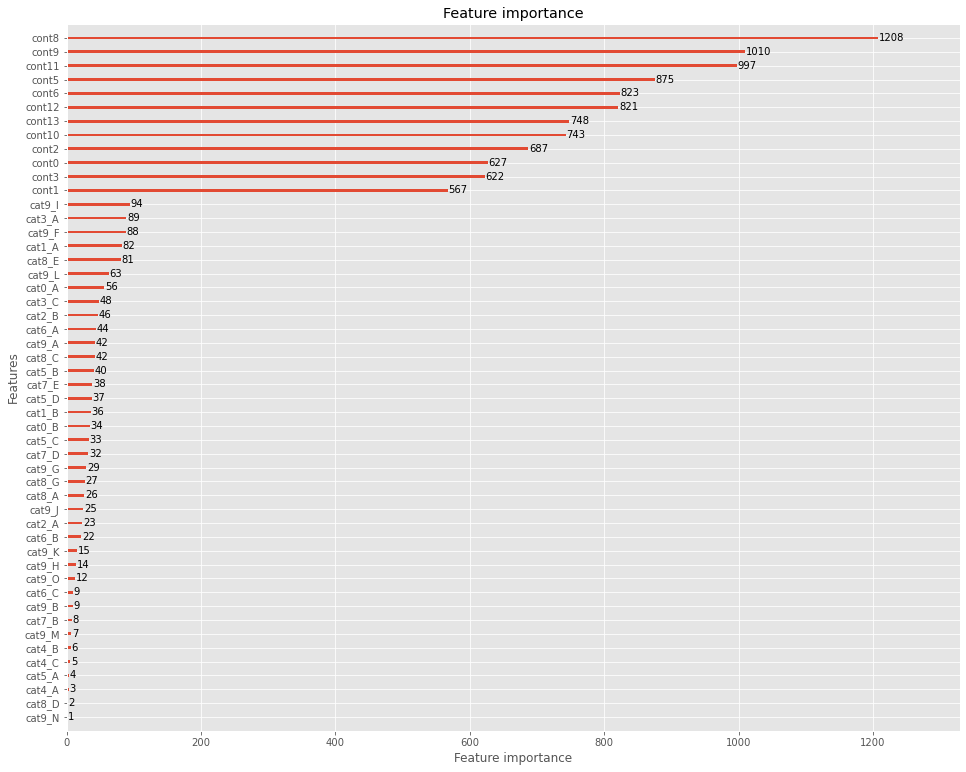

In [34]:
importances = lgb_model.feature_importances_
print(importances)
lgb.plot_importance(lgb_model, figsize=(16, 13))
plt.show()

In [29]:
predictors = ['cont8', 'cont5', 'cont3', 'cont10', 'cont9', 'cont11', 'cont2', 
              'cont1', 'cont12', 'cont6', 'cont0', 'cont13', 'cat0_A', 'cat8_C', 
              'cat9_F', 'cat9_A', 'cat3_C', 'cat1_A', 'cat9_I', 'cat8_E', 'cat3_A', 
              'cat8_G', 'cat9_G', 'cat9_L', 'cat7_D', 'cat6_A', 'cat9_J', 'cat2_B', 
              'cat1_B', 'cat7_E', 'cat5_B', 'cat2_A', 'cat9_K', 'cat5_D', 'cat8_A', 
              'cat5_C', 'cat0_B', 'cat9_H', 'cat6_B', 'cat5_A', 'cat9_O', 'cat9_M', 
              'cat9_N', 'cat9_B', 'cat6_C', 'cat4_B', 'cat8_D', 'cat7_G', 'cat7_B', 
              'cat4_C', 'cat4_A', 'cat8_F']

new_dataset_train = train[predictors]
new_dataset_test = test[predictors]
lgb_model = lgb.LGBMRegressor(boosting="gbdt", max_depth=40, learning_rate=0.1, 
                              reg_alpha=6.147694913504962, reg_lambda= 0.002457826062076097, 
                              colsample_bytree=0.3, subsample=0.8, subsample_freq=6, 
                              min_data_in_leaf=200, min_child_samples = 285, min_data_per_groups = 39, 
                              num_leaves=111)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
i = 1
test_pred = np.zeros(len(test))
for train_idx, val_idx in kf.split(new_dataset_train):
    X_train = new_dataset_train.iloc[train_idx]
    X_val = new_dataset_train.iloc[val_idx]
    y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]
    lgb_model.fit(X_train, y_train)
    print("Fold:", i)
    print("LightGBM on train")
    y_pred_lgb_train = lgb_model.predict(X_train)
    print("RMSE on train (LightGBM):", np.sqrt(mean_squared_error(y_pred_lgb_train, y_train)))
    print("XGBoost on validation")
    y_pred_lgb_val_im = lgb_model.predict(X_val)
    print("RMSE on validation (LightGBM):", np.sqrt(mean_squared_error(y_pred_lgb_val_im, y_val)))
    print("----------------------------------------")
    test_pred += lgb_model.predict(new_dataset_test)
    i += 1

Fold: 1
LightGBM on train
RMSE on train (LightGBM): 0.825716142944188
XGBoost on validation
RMSE on validation (LightGBM): 0.8437617620892015
----------------------------------------
Fold: 2
LightGBM on train
RMSE on train (LightGBM): 0.8252651366433272
XGBoost on validation
RMSE on validation (LightGBM): 0.8462789431556536
----------------------------------------
Fold: 3
LightGBM on train
RMSE on train (LightGBM): 0.8256175967213457
XGBoost on validation
RMSE on validation (LightGBM): 0.8432130278944875
----------------------------------------
Fold: 4
LightGBM on train
RMSE on train (LightGBM): 0.8255461742357797
XGBoost on validation
RMSE on validation (LightGBM): 0.8433134884226532
----------------------------------------
Fold: 5
LightGBM on train
RMSE on train (LightGBM): 0.8256493156096113
XGBoost on validation
RMSE on validation (LightGBM): 0.8445505186138206
----------------------------------------
Fold: 6
LightGBM on train
RMSE on train (LightGBM): 0.8257871406972244
XGBoost on

In [30]:
test_pred /= 10
test_pred

array([7.63269726, 7.81763928, 7.56946732, ..., 7.49286316, 7.52535585,
       7.30277672])

LightGBM with all features is better

### Gradient Boosting

In [31]:
importantces_gboosting = gboosting.feature_importances_
indices = np.argsort(importantces_gboosting)
predictors_gboosting = []
for name, importance in zip(train.columns, gboosting.feature_importances_):
    if importance > 0.00001:
        predictors_gboosting.append(name)
        print(name, "=", importance, "Added")

cont0 = 0.09238110779518188 Added
cont1 = 0.04637861214279269 Added
cont2 = 0.023177402312171965 Added
cont3 = 0.03407558642239196 Added
cont4 = 0.01753401446303616 Added
cont5 = 0.05611753338641461 Added
cont6 = 0.05016949299498207 Added
cont7 = 0.024874424023511085 Added
cont8 = 0.098831643950911 Added
cont9 = 0.06472626050488395 Added
cont10 = 0.029881822370852542 Added
cont11 = 0.06691951586182121 Added
cont12 = 0.025008107474367137 Added
cont13 = 0.07379148701581863 Added
cat0_A = 0.009262161874492476 Added
cat0_B = 0.006156354718941599 Added
cat1_A = 0.03250201485542212 Added
cat1_B = 0.06663416661596196 Added
cat2_A = 0.02375895287397871 Added
cat2_B = 0.025172488702294264 Added
cat3_A = 0.009903338099483558 Added
cat3_B = 0.0003191720259724833 Added
cat3_C = 0.011858405267903376 Added
cat3_D = 0.00013224387404023332 Added
cat4_A = 0.00016057081295147598 Added
cat4_B = 0.00038686626846239563 Added
cat4_C = 0.0003369455429393084 Added
cat4_D = 0.0003324579077600467 Added
cat5_A =

In [32]:
new_dataset_train_gbooting = train[predictors_gboosting]
new_dataset_test_gbooting = test[predictors_gboosting]
gboosting = GradientBoostingRegressor(n_estimators=50, learning_rate=0.2, 
                                      max_depth=6, random_state=1, subsample=0.6)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
i = 1
test_pred_gboosting = np.zeros(len(test))
for train_idx, val_idx in kf.split(new_dataset_train_gbooting):
    X_train, X_val = new_dataset_train_gbooting.iloc[train_idx], new_dataset_train_gbooting.iloc[val_idx]
    y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]
    print("Training........")
    gboosting.fit(X_train, y_train)
    print("Fold:", i)
    print("Gradient Boosting on train")
    y_pred_gboosting_train = gboosting.predict(X_train)
    print("RMSE on train (Gradient Boosting):", np.sqrt(mean_squared_error(y_pred_gboosting_train, y_train)))
    print("XGBoost on validation")
    y_pred_gboosting_val_im = gboosting.predict(X_val)
    print("RMSE on validation (Gradient Boosting):", np.sqrt(mean_squared_error(y_pred_gboosting_val_im, y_val)))
    print("----------------------------------------")
    test_pred_gboosting += gboosting.predict(new_dataset_test_gbooting)
    i += 1

Training........
Fold: 1
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8331535428729853
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.8472964238888625
----------------------------------------
Training........
Fold: 2
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8330028344958681
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.850385170345829
----------------------------------------
Training........
Fold: 3
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8331902166622586
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.8467481982830443
----------------------------------------
Training........
Fold: 4
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.8331430993128562
XGBoost on validation
RMSE on validation (Gradient Boosting): 0.8472373427832052
----------------------------------------
Training........
Fold: 5
Gradient Boosting on train
RMSE on train (Gradient Boosting): 0.

In [33]:
test_pred_gboosting /= 10
test_pred_gboosting

array([7.56719908, 7.83055967, 7.60528298, ..., 7.47405987, 7.52770834,
       7.40283233])

### Ensembling

In [54]:
y_en_val = (0.1 * y_pred_gboosting_val) + (0.9 * y_pred_lgb_val) 
print("RMSE on validation (Gradient Boosting + LightGBM):", 
      np.sqrt(mean_squared_error(y_en_val, y_val)))

RMSE on validation (Gradient Boosting + LightGBM): 0.84922791884861


In [56]:
sub4 = pd.DataFrame()
sub4['id'] = test_id
en_pred = (0.9 * test_pred_lgb) + (0.1 * test_pred_gboosting)
sub4['target'] = en_pred
sub4.to_csv('submission2.csv', index=False)

#### LightGBM with all features still the best with 0.84234, And TOP 50 :)))